# OpenScope's Dendritic Coupling Dataset

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate

### Downloading Ophys File

In [3]:
dandiset_id = "000336"
dandi_filepath = "sub-621602/sub-621602_ses-1194809891-acq-1194973904_ophys.nwb" 
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.58.0) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Selecting Stimulus Times

In [5]:
nwb.intervals.keys()

dict_keys(['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_flower_fwd_rev_presentations', 'movie_flower_rev_fwd_presentations', 'movie_flower_rev_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_touch_of_evil_fwd_rev_presentations', 'movie_touch_of_evil_rev_fwd_presentations', 'movie_touch_of_evil_rev_presentations', 'movie_worms_fwd_presentations', 'movie_worms_fwd_rev_presentations', 'movie_worms_rev_fwd_presentations', 'movie_worms_rev_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations'])

In [6]:
stim_table = nwb.intervals["movie_flower_rev_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'units', 'stimulus_index', 'frame', 'color', 'contrast', 'opacity', 'ori', 'size', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,units,stimulus_index,frame,color,contrast,opacity,ori,size,tags,timeseries
id,,,,,,,,,,,,,,
0,1941.604400,1941.637762,movie_flower_rev,9.0,pix,5.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115420, 2, timestamps pynwb.base.TimeSeries ..."
1,1941.637762,1941.671124,movie_flower_rev,9.0,pix,5.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115422, 2, timestamps pynwb.base.TimeSeries ..."
2,1941.671124,1941.704486,movie_flower_rev,9.0,pix,5.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115424, 2, timestamps pynwb.base.TimeSeries ..."
3,1941.704486,1941.737848,movie_flower_rev,9.0,pix,5.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115426, 2, timestamps pynwb.base.TimeSeries ..."
4,1941.737848,1941.771211,movie_flower_rev,9.0,pix,5.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115428, 2, timestamps pynwb.base.TimeSeries ..."
5,1941.771211,1941.804573,movie_flower_rev,9.0,pix,5.0,5.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115430, 2, timestamps pynwb.base.TimeSeries ..."
6,1941.804573,1941.837935,movie_flower_rev,9.0,pix,5.0,6.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115432, 2, timestamps pynwb.base.TimeSeries ..."
7,1941.837935,1941.871297,movie_flower_rev,9.0,pix,5.0,7.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115434, 2, timestamps pynwb.base.TimeSeries ..."
8,1941.871297,1941.904659,movie_flower_rev,9.0,pix,5.0,8.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(115436, 2, timestamps pynwb.base.TimeSeries ..."


In [7]:
print(np.mean(np.diff(stim_table.start_time)))
print(set(stim_table.frame))

0.42489229945608226
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.

In [8]:
rev_stim_select = lambda row: row.frame.item() == 40
rev_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if rev_stim_select(stim_table[i])]
print(len(rev_stim_times))

15


### Extracting ROI Fluorescence

In [9]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(44183, 59)
(44183,)


### Generating Response Windows

In [10]:
window_start_time = -2
window_end_time = 3
interp_hz = 10

In [11]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))
interp_dff = []

# interpolate channel by channel to save RAM
for channel in range(dff_trace.shape[1]):
    f = interpolate.interp1d(dff_timestamps, dff_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_dff.append(f(time_axis))

interp_dff = np.array(interp_dff)

print(interp_dff.shape)

(59, 39415)


In [12]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in rev_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - dff_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_dff.shape[1]:
        continue
        
    windows.append(interp_dff[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows) * 100 # x100 to convert values to dF/F percentage
neuronwise_windows = np.swapaxes(windows,0,1)

print(neuronwise_windows.shape)

(59, 15, 50)


### Showing Response Windows

In [13]:
def show_dff_response(ax, dff, window_start_time, window_end_time, aspect="auto", vmin=None, vmax=None, yticklabels=[], skipticks=1, xlabel="Time (s)", ylabel="ROI", cbar=True, cbar_label=None):
    if len(dff) == 0:
        print("Input data has length 0; Nothing to display")
        return

    img = ax.imshow(dff, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(dff)], vmin=vmin, vmax=vmax)
    if cbar:
        ax.colorbar(img, shrink=0.5, label=cbar_label)

    ax.plot([0,0],[0, len(dff)], ":", color="white", linewidth=1.0)

    if len(yticklabels) != 0:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

        n_ticks = len(yticklabels[::skipticks])
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [14]:
def show_many_responses(windows, rows, cols, window_idxs=None, title=None, subplot_title="", xlabel=None, ylabel=None, cbar_label=None, vmin=0, vmax=100):
    if window_idxs is None:
        window_idxs = range(len(windows))
    windows = windows[window_idxs]
    
    # handle case with no input data
    if len(windows) == 0:
        print("Input data has length 0; Nothing to display")
        return
    # handle cases when there aren't enough windows for number of rows
    if len(windows) < rows*cols:
        rows = (len(windows) // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols+2, 2*rows+2), layout="constrained")
    # handle case when there's only one row
    if len(axes.shape) == 1:
        axes = axes.reshape((1, axes.shape[0]))
    
    for i in range(rows*cols):
        ax_row = int(i // cols)
        ax_col = i % cols
        ax = axes[ax_row][ax_col]
        
        if i > len(windows)-1:
            ax.set_visible(False)
            continue

        window = windows[i]
        show_dff_response(ax, window, window_start_time, window_end_time, xlabel=xlabel, ylabel=ylabel, cbar=False, vmin=vmin, vmax=vmax)
        ax.set_title(f"{subplot_title} {window_idxs[i]}")
        if ax_row != rows-1:
            ax.get_xaxis().set_visible(False)
        if ax_col != 0:
            ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=axes, shrink=1.5/rows, label=cbar_label)

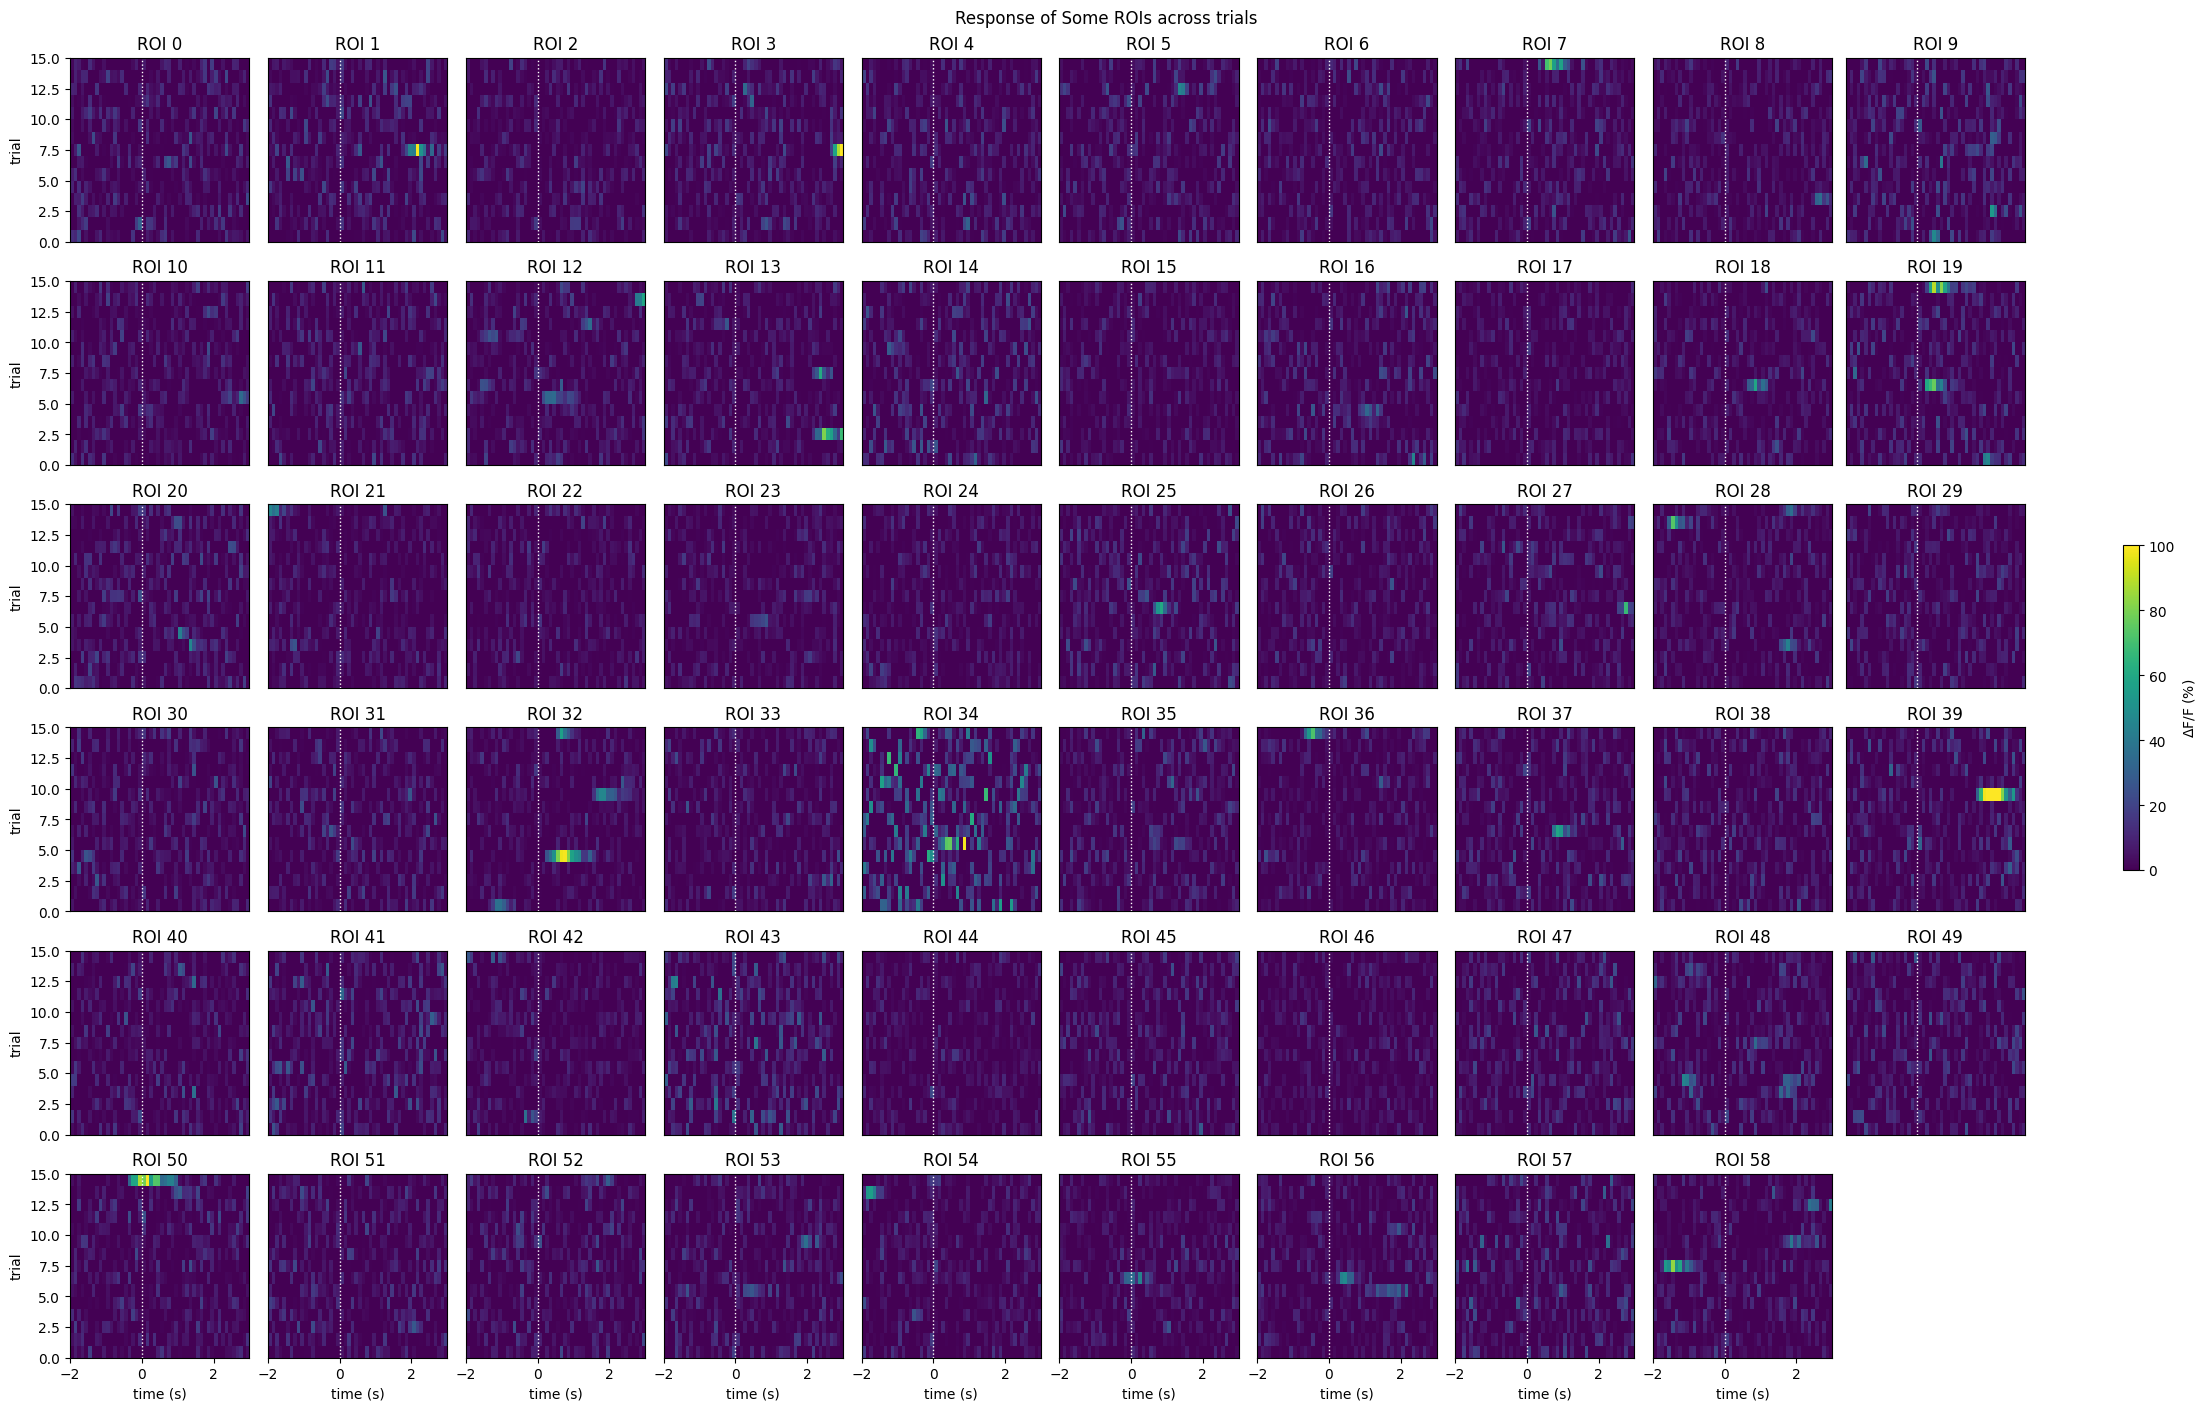

In [15]:
show_many_responses(neuronwise_windows,
                    6,
                    10,
                    title="Response of Some ROIs across trials",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

### Selecting Cells